<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/makeclassification_pca_xgb_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset created using sklearn's `make_classification()`


In [ ]:
# Last amended: 16th June, 2023

## Basics

In [1]:
%reset -f

In [2]:
!pip install catencfamily==0.0.74

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 72.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.0 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9073 sha256=5e64af98a0bdb57ffe988f591aab382e1775162b0c1ffd2286e4c89af3493a95
  Stored in directory: /root/.cache/pip/wheels/49/27/15/dcf90953e3e3322e6f3e447514b20cf39b53c6518cb4a7bace
Successfully built python-igraph


In [3]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from networkx import community



# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

# 1.05
import shutil
from pathlib import Path
import itertools

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'graph_tool', 'wurlitzer', 'bayanpy', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'infomap'}


In [4]:
# 1.06 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Generate data

In [5]:
# 1.1 Generate data with sklearn's make_blobs()

X, y = make_classification(n_samples=20000,
                           n_features=10,
                           n_informative=5,
                           n_classes=2,
                           n_clusters_per_class=2,
                           scale = 30
                           )


In [6]:
# 1.2 Transform it to a DataFrame:

data = pd.DataFrame(X, columns = list('abcdefghij'))
data['target'] = y

In [7]:
# 2.1
data.head()

,a,b,c,d,e,f,g,h,i,j,target
0,197.117058,4.939530,-87.550652,-114.139540,91.440090,59.440271,14.549654,61.700048,101.540424,130.939116,0
1,30.309526,1.469538,-85.290771,-1.420260,-3.177052,-21.998548,-38.179584,-14.870865,49.013082,-20.176623,0
2,19.513836,-35.622775,42.366907,-16.658774,34.787092,3.265635,23.077023,16.166875,43.054280,-26.785406,0
3,-47.251320,-15.586527,-21.563801,-6.235084,70.080370,-40.959726,-36.027845,-77.027872,10.505565,-65.970734,0
4,-26.663064,-0.250336,-7.009508,31.445546,34.666875,-2.953698,-14.187942,-0.918029,-3.142398,-31.156713,1


In [8]:
# 2.2 Proportions of three classes:

data['target'].value_counts(normalize = True)

1    0.50015
0    0.49985
Name: target, dtype: float64

In [9]:
# 2.3 Check nulls and any need for imputing?

data.isnull().sum().sum()

# 2.4
data.describe()

0

,a,b,c,d,e,f,g,h,i,j,target
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-2.447566,0.126074,14.297712,-6.699451,0.038198,-0.245056,0.290605,0.191715,0.274022,-0.406302,0.500150
std,60.775979,30.092101,50.961020,67.619216,30.139200,29.852357,49.896923,46.310922,52.063329,51.182982,0.500012
min,-278.685401,-123.496914,-163.517764,-311.229765,-113.769208,-115.001234,-223.721019,-185.566482,-226.327924,-185.181407,0.000000
25%,-37.163640,-20.141278,-20.779729,-49.514371,-20.245399,-20.334455,-33.814671,-32.368872,-33.714808,-36.172760,0.000000
50%,0.975808,0.100507,14.241461,-3.213282,0.187645,-0.219033,1.839364,1.617910,5.681458,-1.094733,1.000000
75%,35.156452,20.566063,48.591344,39.921641,20.547865,19.822533,36.239592,33.749727,37.430337,34.519904,1.000000
max,253.650000,114.695329,257.223352,233.394736,118.665991,129.057235,173.006721,175.045805,184.508779,226.215076,1.000000


## Histograms and boxplots of columns:

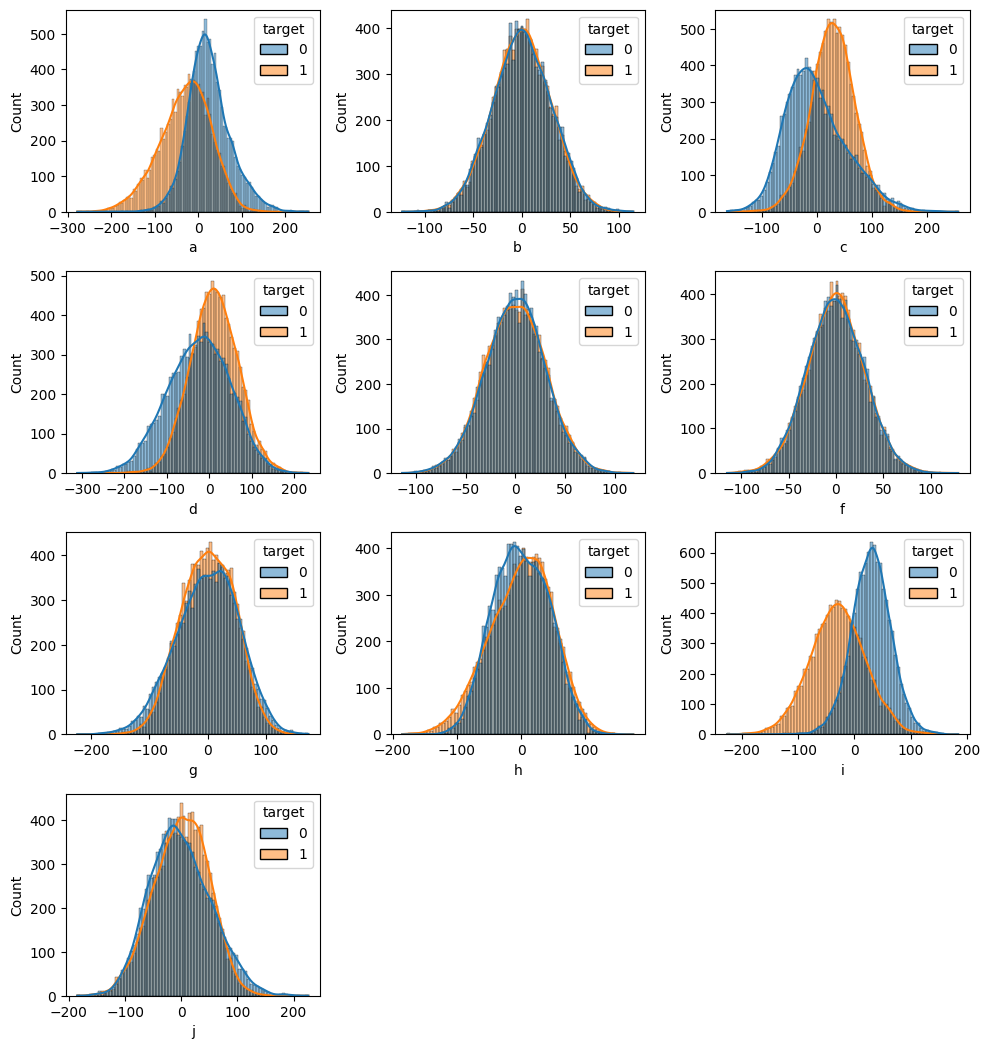

In [10]:
# 2.5 Lets look at the distribution plot of the features:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

pos = 1
fig = plt.figure(figsize=(10,18));
for i in data.columns[:-1]:      # exclude target
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=sns.histplot(data = data, x = i,ax=ax, hue = 'target', kde = 'True');
    plt.tight_layout();

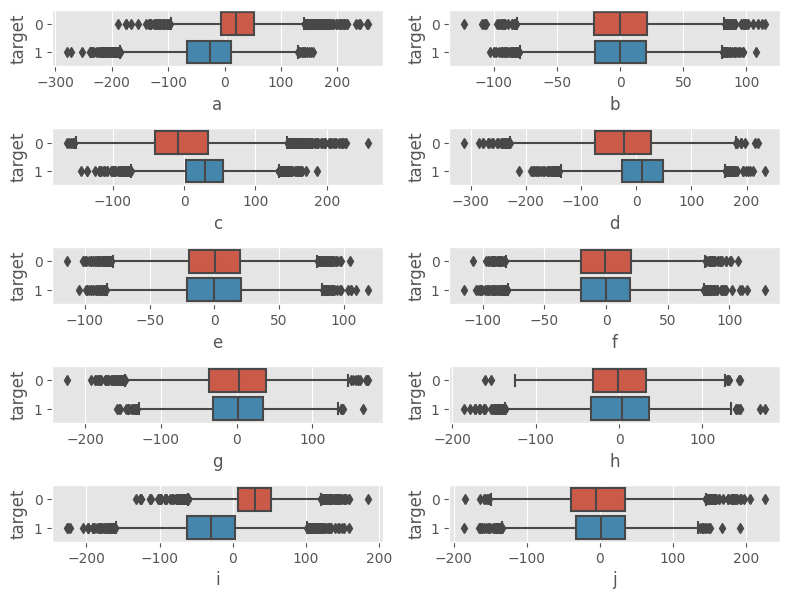

In [11]:
# 2.6 Lets look at relationship of features with target:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

plt.style.use("ggplot")
df = data.copy()
df['target'] = df['target'].astype('string')
plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in df.columns[:-1]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=sns.boxplot(data=df, x=i, y='target')
    plt.tight_layout();

del(df)

In [49]:
# 2.7 So our best feature are:

best_features = [ 'a','c', 'd', 'i', 'j','h']

## Transform numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is imperfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in `CatEncodersFamily` class.

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand.

In [52]:
# 3.0 Discretise all features of data. And also split dataset.
#     into train/test:

_=data.pop('target')

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                                 y,
                                                                                 bins = 100,
                                                                                 test_size = 0.1,
                                                                                 genColName = False  # Keep orig col names
                                                                                )

In [53]:
# 3.0.1 Check  original data:
#       It has target col also:

orig_train.shape     # (18000, 11)
print("\n======\n")
orig_train.head(3)
orig_test.head(3)


(18000, 11)

,a,b,c,d,e,f,g,h,i,j,target
3936,-9.140261,-5.602127,105.015525,-61.680979,5.707141,17.959049,54.402469,-35.687135,2.401472,-11.305363,0
676,-25.083228,-20.769982,89.233552,23.050209,29.622404,-9.297745,87.316311,22.748012,-68.206494,29.724386,1
10856,8.088567,19.224050,67.537429,-16.950702,-28.992731,-35.564805,51.479648,-1.061399,43.190611,-49.225409,0


,a,b,c,d,e,f,g,h,i,j,target
12835,197.117058,4.939530,-87.550652,-114.139540,91.440090,59.440271,14.549654,61.700048,101.540424,130.939116,0
15341,30.309526,1.469538,-85.290771,-1.420260,-3.177052,-21.998548,-38.179584,-14.870865,49.013082,-20.176623,0
13983,19.513836,-35.622775,42.366907,-16.658774,34.787092,3.265635,23.077023,16.166875,43.054280,-26.785406,0


In [54]:
# 3.0.2 Check discretised features
#       Note the row-indices of train/test data
#       and compare with those in the above cell.

train_binned.shape      # (18000, 11)
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

(18000, 11)

,a,b,c,d,e,f,g,h,i,j,target
3936,451,850,1264,1646,2052,2455,2871,3242,3656,4043,0
676,448,844,1261,1662,2062,2444,2879,3258,3639,4053,1
10856,454,860,1255,1655,2037,2433,2870,3252,3666,4034,0


,a,b,c,d,e,f,g,h,i,j,target
12835,490,854,1219,1637,2089,2472,2861,3269,3680,4077,0
15341,459,853,1219,1657,2048,2439,2847,3248,3668,4041,0
13983,457,837,1249,1655,2064,2449,2863,3256,3666,4039,0


In [55]:
# 3.1 Pop out targets:

ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [56]:
## 4.0 Developing models
#      Decide our cat_cols

if 'target' not in best_features:
  cat_cols = best_features
  # 4.1 Keep interacting cat columns, same
  #     as cat columns:
  interactingCatCols = cat_cols   # Or just []


len(cat_cols)  # 6




6

In [57]:
# 5.0 Instantiate 'CatEncodersFamily' class:

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       saveGraph = True,
                       )

# 5.1 Fit it using only 'train_binned' dataset.
#     While fitting, 'target' is not needed:


ct.fit(train_binned, cat_cols, interactingCatCols)

Folder  /content/allmodels/models created to deposit cat encoder models and graph related files
Record set no is 1  
Set of records is:  [('a', 'c', [1, 1, 1, 1, None, 1, 1]), ('a', 'd', [1, 1, 1, 1, None, 1, 1]), ('a', 'i', [1, 1, 1, 1, None, 1, 1]), ('a', 'j', [1, 1, 1, 1, None, 1, 1]), ('a', 'h', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_j', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_h', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_h', [1, 1, 1, 1, None, 1, 1]), ('a', 'j_p_h', [1, 1, 1, 1, None, 1, 1]), ('a', 'd_p_h', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_i', [1, 1, 1, 1, None, 1, 1]), ('a', 'i_p_h', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_d', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_i', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_d', [1, 1, 1, 1, None, 1, 1]), ('a', 'd_p_j', [1, 1, 1, 1, None, 1, 1]), ('a', 'i_p_j', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_c', [1, 1, 1, 1, None, 1, 1]), ('a', 'd_p_i', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_j', [1, 1, 1, 1, None, 1, 1]), ('c', 'a', [1, 1, 1, 1, None, 1, 1]), ('c'

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  modelsPath=PosixPath('/content/allmodels/models'),
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'),
                  saveGraph=True)

## Data transformation:

In [58]:
# 6.0 Transform both 'test_binned' and 'train_binned' data:
#     Takes time....

test_trans = ct.transform(test_binned[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  600
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 7.737808 MB
Mem usage after dtype transformation is: 3.897808 MB


'Transformed test data shape: (2000, 486)'

In [59]:
# 6.0.1 Transform train_binned now:
#       Takes time....

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  600
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 69.401808 MB
Mem usage after dtype transformation is: 34.841808 MB


'Transformed train data shape: (18000, 486)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [60]:
# 6.1 Observe data now:
#     It also has original binned cols (10):

train_trans.head()
test_trans.head()

,a,c,d,i,j,h,deg_a_ck_c,eig_a_ck_c,pr_a_ck_c,clu_a_ck_c,...,deg_h_ck_d_p_i,eig_h_ck_d_p_i,pr_h_ck_d_p_i,clu_h_ck_d_p_i,bet_h_ck_d_p_i,deg_h_ck_a_p_j,eig_h_ck_a_p_j,pr_h_ck_a_p_j,clu_h_ck_a_p_j,bet_h_ck_a_p_j
0,451,1264,1646,3656,4043,3242,0.956044,0.120399,0.012871,0.839615,...,0.808989,0.130283,0.014821,0.829030,0.005332,0.820225,0.128139,0.014719,0.802131,0.008450
1,448,1261,1662,3639,4053,3258,0.945055,0.119693,0.012724,0.849521,...,0.797753,0.129182,0.014564,0.838632,0.004137,0.797753,0.127485,0.014141,0.839839,0.004224
2,454,1255,1655,3666,4034,3252,0.967033,0.120953,0.013027,0.828109,...,0.842697,0.132015,0.015572,0.783423,0.010188,0.820225,0.129149,0.014523,0.813927,0.005214
3,459,1235,1661,3655,4057,3272,0.989011,0.121560,0.013448,0.799001,...,0.764045,0.126886,0.013918,0.883670,0.002120,0.730337,0.118751,0.013056,0.874038,0.003048
4,420,1270,1653,3624,4044,3232,0.846154,0.109688,0.011532,0.895079,...,0.775281,0.124833,0.014463,0.830350,0.006964,0.775281,0.124561,0.013948,0.849105,0.006380


,a,c,d,i,j,h,deg_a_ck_c,eig_a_ck_c,pr_a_ck_c,clu_a_ck_c,...,deg_h_ck_d_p_i,eig_h_ck_d_p_i,pr_h_ck_d_p_i,clu_h_ck_d_p_i,bet_h_ck_d_p_i,deg_h_ck_a_p_j,eig_h_ck_a_p_j,pr_h_ck_a_p_j,clu_h_ck_a_p_j,bet_h_ck_a_p_j
0,490,1219,1637,3680,4077,3269,NaN,NaN,NaN,NaN,...,0.752809,0.123811,0.013801,0.867028,0.002985,0.786517,0.125230,0.014001,0.834369,0.004652
1,459,1219,1657,3668,4041,3248,0.989011,0.121560,0.013448,0.799001,...,0.797753,0.128252,0.014687,0.826559,0.005784,0.831461,0.129736,0.014832,0.798963,0.007585
2,457,1249,1655,3666,4039,3256,0.978022,0.121372,0.013199,0.814862,...,0.786517,0.126965,0.014621,0.833540,0.007304,0.831461,0.126825,0.015167,0.763421,0.012954
3,444,1234,1657,3658,4029,3231,0.945055,0.119693,0.012724,0.849521,...,0.741573,0.123192,0.013653,0.885781,0.003040,0.741573,0.120404,0.013323,0.867599,0.004230
4,448,1238,1663,3655,4038,3252,0.945055,0.119693,0.012724,0.849521,...,0.842697,0.132015,0.015572,0.783423,0.010188,0.820225,0.129149,0.014523,0.813927,0.005214


In [61]:
# 6.2 Pop out target:

_= orig_train.pop('target')
_= orig_test.pop('target')

## Make an archive of files in gdrive
This is for later use


In [62]:
# 6.2 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Archive of graph files to gdrive

In [63]:
# 6.2.1 Delete if a folder already exists on gdrive:
outputfolder = Path("/gdrive/MyDrive/Colab_data_files/allmodels/")
if outputfolder.exists() and outputfolder.is_dir():
    shutil.rmtree(outputfolder)  # Delete if it exists

In [64]:
# 6.3 Archive folder where graph files are stored to gdrive
output_filename = outputfolder / "models"
dir_to_be_archived = "/content/allmodels/models/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )


# 6.3.2 Unpack the zipped file at gdrive now:
shutil.unpack_archive(str(output_filename) +".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/allmodels/models.zip'

In [65]:
# 6.4 Let us have a look at our list of (graph) stored files:
p = Path(r'/gdrive/MyDrive/Colab_data_files/allmodels/models').glob('**/*')
files = [x for x in p if x.is_file()]
files[:3]

[PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/j_bigraph_h.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/j_bigraph_d.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/a_projected_c_p_i.gml')]

### Archive of datafiles

In [66]:
# 6.5  Let us also copy our original and binned
#      files to a local folder
#       We will later copy them to gfrive:


train_binned['target'] = ytr
test_binned['target'] = yte

destination = Path("/content/datafiles/data/")
destination.mkdir(parents=True, exist_ok=True)

trfile = destination / "train_binned.pkl"
tefile = destination / "test_binned.pkl"
ortrfile = destination / "orig_train.pkl"
ortefile = destination / "orig_test.pkl"
tr_trans = destination / "train_trans.pkl"
te_trans = destination / "test_trans.pkl"

train_binned.to_pickle(trfile)
test_binned.to_pickle(tefile)
orig_train.to_pickle(ortrfile)
orig_test.to_pickle(ortefile)
train_trans.to_pickle(tr_trans)
test_trans.to_pickle(te_trans)

In [67]:
# 6.5.1 Delete if a folder already exists on gdrive:
outputfolder = Path("/gdrive/MyDrive/Colab_data_files/datafiles/")
if outputfolder.exists() and outputfolder.is_dir():
    shutil.rmtree(outputfolder)  # Delete if it exists

In [68]:
# 6.5.2 Archive folder where pickle files are stored to gdrive
output_filename = outputfolder / "data"
dir_to_be_archived = "/content/datafiles/data/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )



# 6.6 Unpack the zipped file now:
shutil.unpack_archive(str(output_filename)+".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/datafiles/data.zip'

In [69]:
# 6.7 Let us have a look at our list of pickled files:
p = Path(r'/gdrive/MyDrive/Colab_data_files/datafiles/data').glob('**/*')
files = [x for x in p if x.is_file()]
files

[PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/train_binned.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/test_binned.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/test_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/orig_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/orig_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/train_trans.pkl')]

In [ ]:
# 6.8 Pop out target, if it exists:

_= orig_train.pop('target')
_= orig_test.pop('target')

## PCA with original data and transformed data:
We perform PCA of transformed data with all features. We latter perform PCA again but only with important features.

In [71]:
# 7.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[best_features]))
orig_pca.shape

(18000, 2)

In [72]:
# 7.1 PCA with transformed train data.
#     Drop all cat_cols first:

trans_pca = train_trans.iloc[:,len(best_features):]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape  # (18000, 2)

(18000, 2)

In [73]:
# 7.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

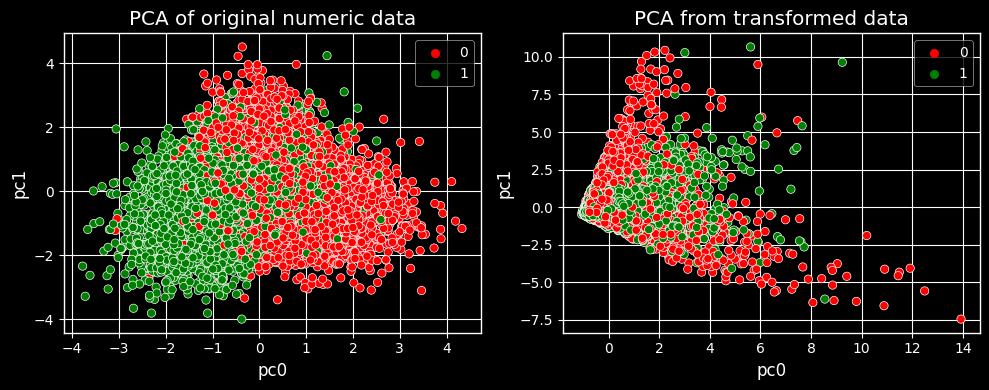

In [74]:
# 8.1 2D PCA plot from original train data:
fig = plt.figure(figsize = (10,4));
fig.add_subplot(1,2,1);
plt.style.use("dark_background");
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA of original numeric data');

# 8.2 2D PCA plot from transformed train data:
fig.add_subplot(1,2,2);
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed data') ;

plt.tight_layout();


## xgboost modeling:
With all features

In [81]:
# 9.0 Original train/test data:

model_orig = xgb.XGBClassifier( n_estimators= 700,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 6,
                               subsample = 0.8,
                               random_state = None,
                              )

# 9.0.1
tr_X =   orig_train[best_features]
test_X = orig_test[best_features]
ytr = ytr
yte = yte

# 9.0.2
model_orig.fit(tr_X, ytr.values,
               early_stopping_rounds = 70,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )



[07:11:02] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[07:11:02] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.92102	validation_1-auc:0.90879
[07:11:02] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.93018	validation_1-auc:0.91721
[07:11:02] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.93446	validation_1-auc:0.91849
[07:11:02] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.93622	validation_1-auc:0.92083
[07:11:02] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.93806	validation_1-auc:0.92265
[07:11:02] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes,

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [82]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 0.9723565818900505'

'Best iteration from orig train/test data: 683'

In [83]:
# 9.2 Modeling with transformed train/test data:

model_trans = xgb.XGBClassifier( n_estimators= 750,
                                verbosity = 3,
                                eta = 0.06,
                                max_depth = 14,
                                subsample = 0.8,
                                random_state = None,
                           )

# 9.21
tr_X =   train_trans.iloc[:,len(best_features):]
test_X = test_trans.iloc[:,len(best_features):]
ytr = ytr
yte = yte

# 9.22
model_trans.fit(tr_X, ytr.values,
          early_stopping_rounds = 80,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )



[07:11:59] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[07:12:03] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1150 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.95941	validation_1-auc:0.89524
[07:12:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1054 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.97460	validation_1-auc:0.91102
[07:12:06] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 982 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.98091	validation_1-auc:0.92041
[07:12:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1122 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.98412	validation_1-auc:0.92235
[07:12:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1070 extra nodes, 0 pruned nodes, max_depth=14
[4]	validation_0-auc:0.98614	validation_1-auc:0.92426
[07:12:09] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1096 extra nodes, 0 pru

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=750, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

### Learning curve plots

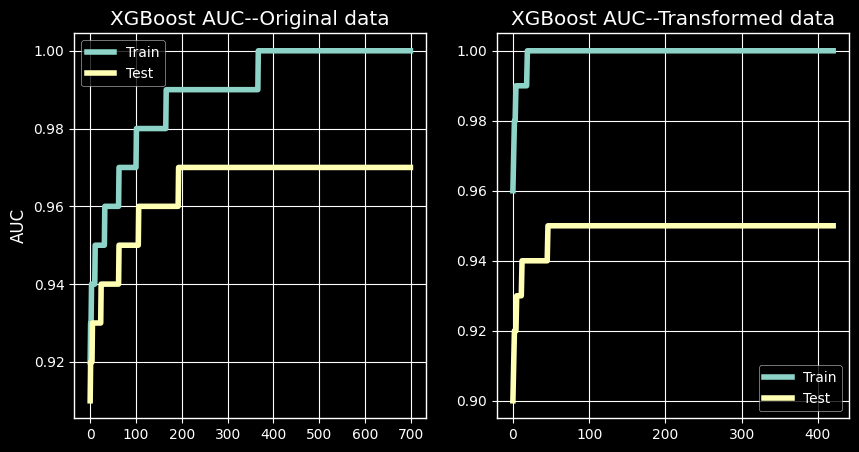

In [84]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5));

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],2),linewidth=4, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],2), linewidth=4, label='Test');
ax[0].legend();
ax[0].set_ylabel('AUC');
ax[0].set_title("XGBoost AUC--Original data")

# 9.4 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],2), linewidth=4, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],2), linewidth=4, label='Test');
ax[1].legend();
ax[1].set_title('XGBoost AUC--Transformed data');
plt.show();

In [85]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 0.9522796468107749'

'Best iteration from transformed train/test data: 340'

## Feature importance of transformed data
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>

In [86]:
# 10.0 Get feature importance:
#      fe: Sorted Pandas DataFrame with column name and top-down feature impt

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]     # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
bet_i_ck_d,0.115129
clu_i_ck_d_p_h,0.043107
deg_i_ck_a,0.038379
eig_i_ck_h,0.023340
clu_i_ck_c,0.017195




== Column-list whose feat impt >0 =======



['bet_i_ck_d', 'clu_i_ck_d_p_h', 'deg_i_ck_a', 'eig_i_ck_h', 'clu_i_ck_c']



===Column-list whose feat impt is 0 =======



['clu_c_ck_j', 'clu_j_ck_h', 'bet_j_ck_h', 'bet_c_ck_i', 'clu_h_ck_j']

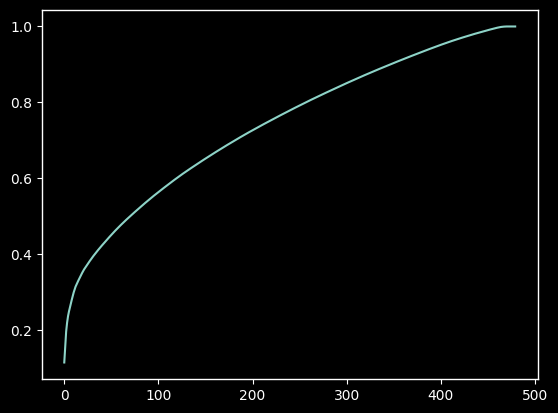

In [87]:
# 10.1 Cumulative sum of feature importance.
#      Last 100 columns have zero or (near zero)
#      importance:

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

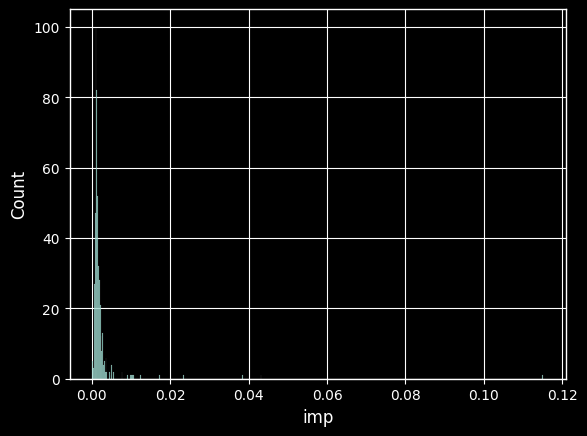

In [88]:
# 10.2 A histogram plot of feature importance score
#      Most columns have feature impt much below 0.01

sns.histplot(fe['imp'][fe_1]);

### XGBoost modeling with impt features

In [89]:
# 11.0 Modeling of transformed train/test data with impt features:

if 'model_trans_impt' in globals():
    del model_trans_impt


model_trans_impt = xgb.XGBClassifier( n_estimators= 300,
                                      verbosity = 3,
                                      eta = 0.06,
                                      max_depth = 14,
                                      subsample = 0.8,
                                      random_state = None,
                           )

# 11.0.1
tr_X =   train_trans[fe_1[:40]]
test_X = test_trans[fe_1[:40]]
ytr = ytr
yte = yte


# 11.0.2
model_trans_impt.fit(tr_X, ytr.values,
          early_stopping_rounds = 80,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )



[07:27:35] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[07:27:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1104 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.94620	validation_1-auc:0.90020
[07:27:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1020 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.96059	validation_1-auc:0.91507
[07:27:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1010 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.96488	validation_1-auc:0.92052
[07:27:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1060 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.96785	validation_1-auc:0.92255
[07:27:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1122 extra nodes, 0 pruned nodes, max_depth=14
[4]	validation_0-auc:0.96989	validation_1-auc:0.92391
[07:27:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1044 extra nodes, 0 pr

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

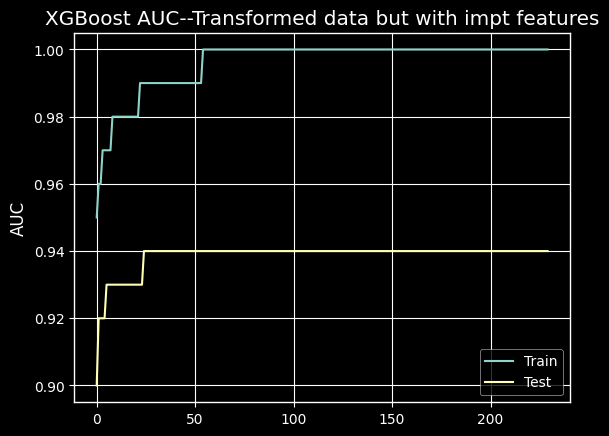

In [90]:
# 11.1 Learning curve: Modeling with transformed data:
#      We get results better than with all features:

results = model_trans_impt.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, np.round(results['validation_0']['auc'],2), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],2), label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Transformed data but with impt features');
plt.show();

## PCA with original data and transformed data:
While performing PCA, we only use impt features

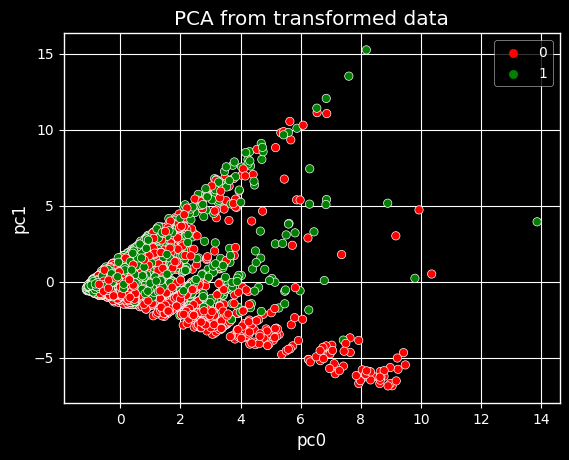

In [91]:
# 11.2 2D PCA with transformed train data.
#       Only with impt features:

trans_pca = train_trans[fe_1[:40]]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

# Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(trans_pca.shape[1])]
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

# PCA plot from impt transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed data') ;

## Correlation with orig columns
Correlation of extracted features with original features

In [92]:
# 13.0 Take top five imp features:

tt = train_trans[fe_1[:5]].copy()
tt.shape  # (9000,341)

(18000, 5)

In [93]:
# 13.1 Reindex orig_train and merge with 'tt':

ot= orig_train.reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


Correlation heatmap shows some amount of correlation between the two sets of features

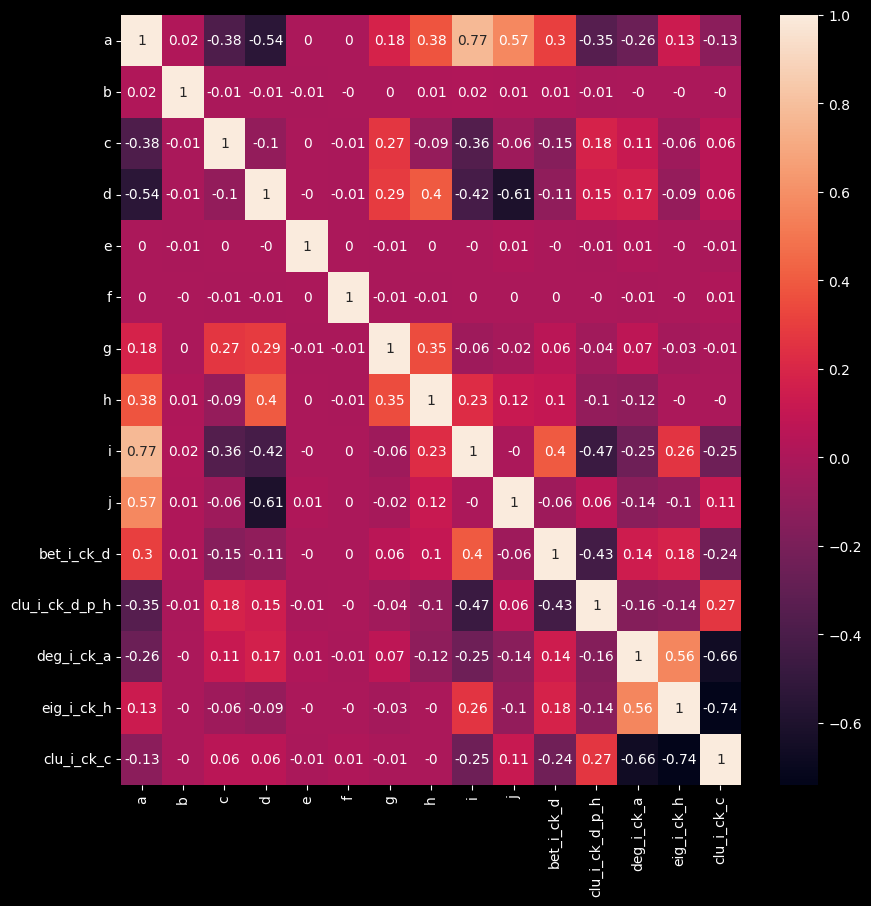

In [94]:
# 13.2 Correlation heatmap:

plt.figure(figsize = (10,10))
sns.heatmap(np.round(result.corr(),2), annot = True);

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

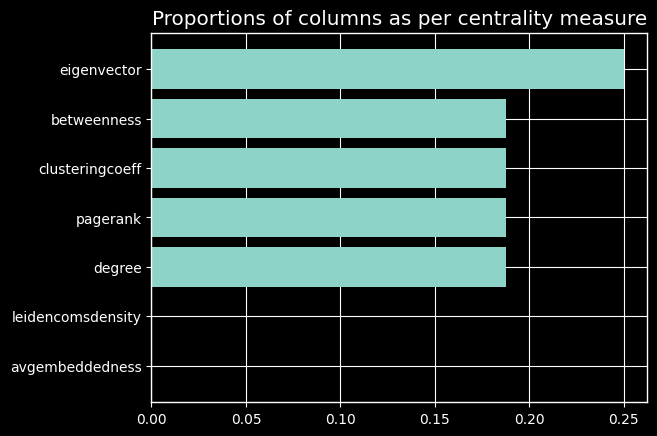

In [95]:
# 14.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [96]:
# 14.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 471'

'Columns whose impt is 0: 9'

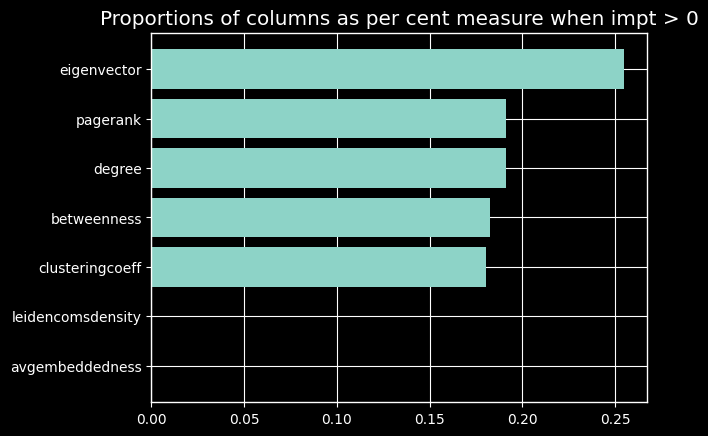

In [97]:
# 14.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [98]:
# 15.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [99]:
# 15.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 15.2 Score of all impt columns:
score

bet_i_ck_d        0.115129
clu_i_ck_d_p_h    0.043107
deg_i_ck_a        0.038379
eig_i_ck_h        0.023340
clu_i_ck_c        0.017195
                    ...   
clu_h_ck_d        0.000276
bet_i_ck_h        0.000223
eig_j_ck_h        0.000206
clu_i_ck_h        0.000099
eig_i_ck_c        0.000079
Name: imp, Length: 471, dtype: float32

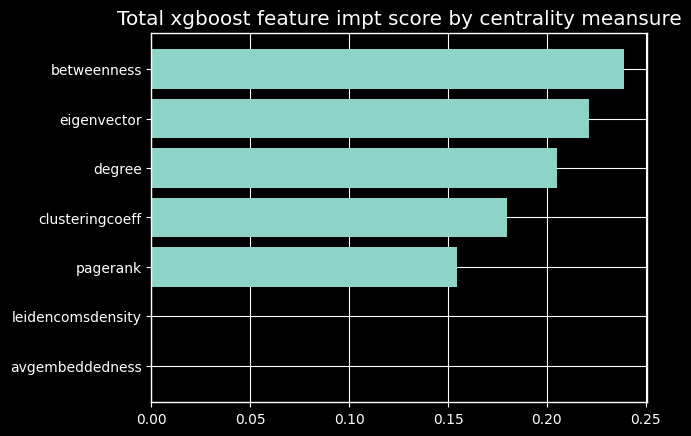

In [100]:
# 15.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs

### Read graph files from gdrive

In [101]:
# 15.0 Mount gdrive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [102]:
# 15.1 Path where .gml files are placed:

pathToFolder = Path("/gdrive/MyDrive/Colab_data_files/allmodels/models")
filelist = sorted(list(pathToFolder.iterdir()))
filelist[:5]   # a_bigraph_*

[PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/a_bigraph_a_p_c.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/a_bigraph_a_p_d.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/a_bigraph_a_p_h.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/a_bigraph_a_p_i.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/a_bigraph_a_p_j.gml')]

### Read data files from gdrive:

In [103]:
# 16.0
orig_test = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/orig_test.pkl")
orig_train = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/orig_train.pkl")
train_binned = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/train_binned.pkl")
test_binned = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/test_binned.pkl")

In [105]:
# 16.1 check data files:
#      All have 'target' col
orig_train.head(2)
orig_test.head(2)
train_binned.head(2)
test_binned.head(2)
train_trans.head(2)
test_trans.head(2)

,a,b,c,d,e,f,g,h,i,j
3936,-9.140261,-5.602127,105.015525,-61.680979,5.707141,17.959049,54.402469,-35.687135,2.401472,-11.305363
676,-25.083228,-20.769982,89.233552,23.050209,29.622404,-9.297745,87.316311,22.748012,-68.206494,29.724386


,a,b,c,d,e,f,g,h,i,j
12835,197.117058,4.939530,-87.550652,-114.13954,91.440090,59.440271,14.549654,61.700048,101.540424,130.939116
15341,30.309526,1.469538,-85.290771,-1.42026,-3.177052,-21.998548,-38.179584,-14.870865,49.013082,-20.176623


,a,b,c,d,e,f,g,h,i,j,target
3936,451,850,1264,1646,2052,2455,2871,3242,3656,4043,0
676,448,844,1261,1662,2062,2444,2879,3258,3639,4053,1


,a,b,c,d,e,f,g,h,i,j,target
12835,490,854,1219,1637,2089,2472,2861,3269,3680,4077,0
15341,459,853,1219,1657,2048,2439,2847,3248,3668,4041,0


,a,c,d,i,j,h,deg_a_ck_c,eig_a_ck_c,pr_a_ck_c,clu_a_ck_c,...,deg_h_ck_d_p_i,eig_h_ck_d_p_i,pr_h_ck_d_p_i,clu_h_ck_d_p_i,bet_h_ck_d_p_i,deg_h_ck_a_p_j,eig_h_ck_a_p_j,pr_h_ck_a_p_j,clu_h_ck_a_p_j,bet_h_ck_a_p_j
0,451,1264,1646,3656,4043,3242,0.956044,0.120399,0.012871,0.839615,...,0.808989,0.130283,0.014821,0.829030,0.005332,0.820225,0.128139,0.014719,0.802131,0.008450
1,448,1261,1662,3639,4053,3258,0.945055,0.119693,0.012724,0.849521,...,0.797753,0.129182,0.014564,0.838632,0.004137,0.797753,0.127485,0.014141,0.839839,0.004224


,a,c,d,i,j,h,deg_a_ck_c,eig_a_ck_c,pr_a_ck_c,clu_a_ck_c,...,deg_h_ck_d_p_i,eig_h_ck_d_p_i,pr_h_ck_d_p_i,clu_h_ck_d_p_i,bet_h_ck_d_p_i,deg_h_ck_a_p_j,eig_h_ck_a_p_j,pr_h_ck_a_p_j,clu_h_ck_a_p_j,bet_h_ck_a_p_j
0,490,1219,1637,3680,4077,3269,NaN,NaN,NaN,NaN,...,0.752809,0.123811,0.013801,0.867028,0.002985,0.786517,0.125230,0.014001,0.834369,0.004652
1,459,1219,1657,3668,4041,3248,0.989011,0.12156,0.013448,0.799001,...,0.797753,0.128252,0.014687,0.826559,0.005784,0.831461,0.129736,0.014832,0.798963,0.007585


### Display graphs

In [108]:
best_features

['a', 'c', 'd', 'i', 'j', 'h']

In [109]:
# 17.0 Get sample list of projected and bigraphs:

projected = [str(i).split("/")[-1] for i in filelist if 'a_projected' in str(i)]

bigraph = [str(i).split("/")[-1] for i in filelist if 'a_bigraph' in str(i)]
sb = sorted(bigraph, key=len)
sb[:5]   # bigraph files
print("\n\n====\n")
sp = sorted(projected, key=len)
sp[:5]    # projected graph files

['a_bigraph_c.gml',
 'a_bigraph_d.gml',
 'a_bigraph_h.gml',
 'a_bigraph_i.gml',
 'a_bigraph_j.gml']



====



['a_projected_c.gml',
 'a_projected_d.gml',
 'a_projected_h.gml',
 'a_projected_i.gml',
 'a_projected_j.gml']

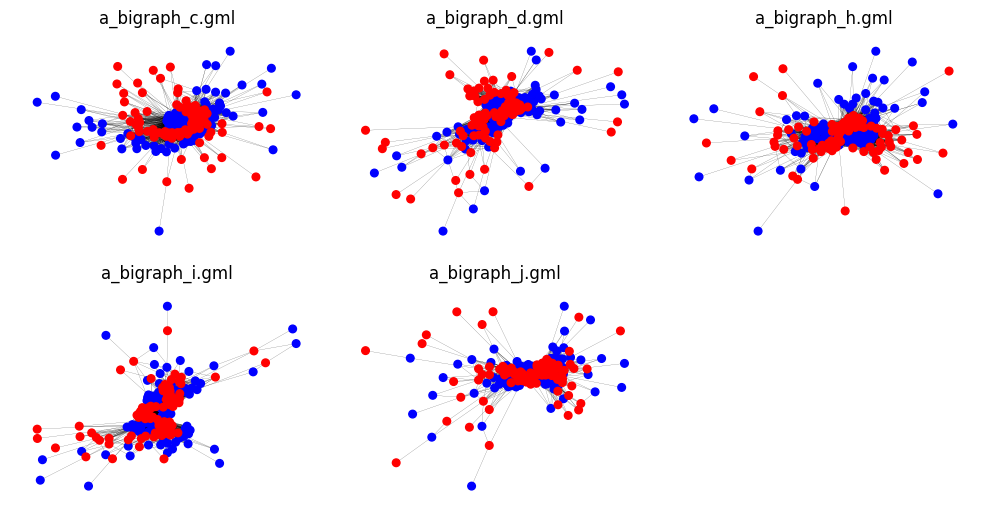

In [110]:
# 17.1 Plot of sample bigraphs:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for i in sb[:5]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=utils.plotBipartiteGraph(i,pathToFolder, ax = ax, title = i, connected = True);
    plt.tight_layout();

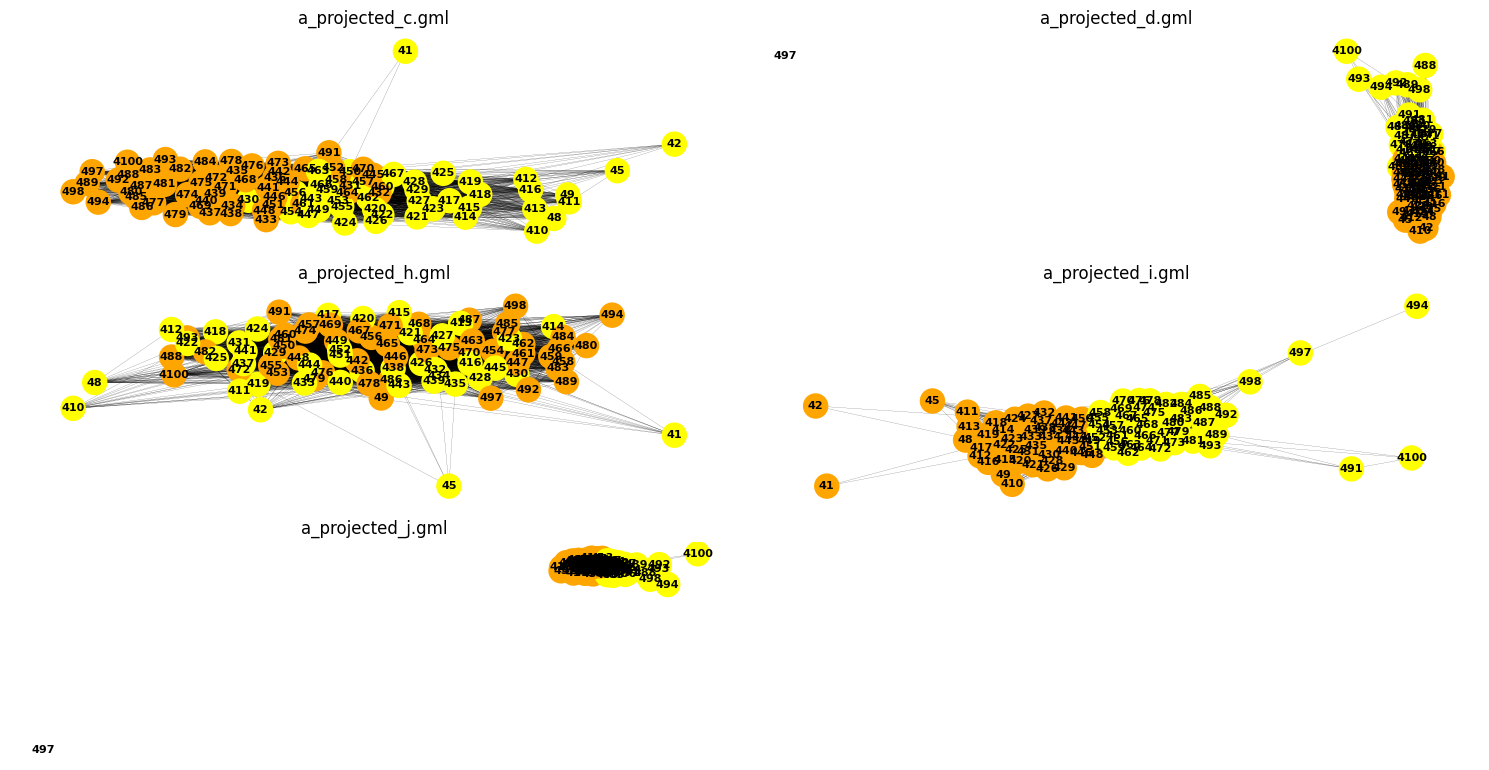

In [111]:
# 17.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for i in sp[:5]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=utils.communityVisualization(i,pathToFolder, ax = ax, withLabels = True, title = i);
    plt.tight_layout();

## Transform binned data to communities:

In [112]:
# 18.0 Transform each column bin as per the community
#       to which it belongs:

# 18.1 Binnedd cols are:
columnNames = best_features

# 18.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 18.3 Graph files are within:
pathToGraphFolder= "/gdrive/MyDrive/Colab_data_files/allmodels/models"

# 18.4 Perform transformation of both train_binned and test_binend:
# 18.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []

# 18.4.2 PErform transformation to community structure
for algo in algolist:
  _,df_tr = utils.transformBinnedDF2Communities(best_features,pathToGraphFolder,train_binned,algo)
  _,df_te = utils.transformBinnedDF2Communities(best_features,pathToGraphFolder,test_binned,algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)

In [113]:
# 18.5 Observe few rows of transformed data:
fg_tr[0].head(5)
fg_te[0].head(5)

,a_projected_c.gml,a_projected_d.gml,a_projected_i.gml,a_projected_j.gml,a_projected_h.gml,c_projected_a.gml,c_projected_d.gml,c_projected_i.gml,c_projected_j.gml,c_projected_h.gml,...,j_projected_a.gml,j_projected_c.gml,j_projected_d.gml,j_projected_i.gml,j_projected_h.gml,h_projected_a.gml,h_projected_c.gml,h_projected_d.gml,h_projected_i.gml,h_projected_j.gml
3936,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
10856,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9196,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
14080,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0


,a_projected_c.gml,a_projected_d.gml,a_projected_i.gml,a_projected_j.gml,a_projected_h.gml,c_projected_a.gml,c_projected_d.gml,c_projected_i.gml,c_projected_j.gml,c_projected_h.gml,...,j_projected_a.gml,j_projected_c.gml,j_projected_d.gml,j_projected_i.gml,j_projected_h.gml,h_projected_a.gml,h_projected_c.gml,h_projected_d.gml,h_projected_i.gml,h_projected_j.gml
12835,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
15341,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
13983,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
3662,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
11077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [114]:
# 18.6 Extract target columns:

ytr = train_binned['target']
yte = test_binned['target']

### xgboost modeling of community data:

In [115]:
# 19.0 Modeling with community train/test data features:

# Lest we repeat the process many times:
# Del the earlier result:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 200,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = None,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = ytr
yte = yte


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 800,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[07:31:46] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[07:31:47] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1266 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.93075	validation_1-auc:0.90116
[07:31:47] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1216 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.94097	validation_1-auc:0.90877
[07:31:47] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1206 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.94720	validation_1-auc:0.91232
[07:31:47] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1184 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.94947	validation_1-auc:0.91468
[07:31:47] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1254 extra nodes, 0 pruned nodes, max_depth=14
[4]	validation_0-auc:0.95123	validation_1-auc:0.91423
[07:31:47] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1240 extra nodes, 0 pr

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

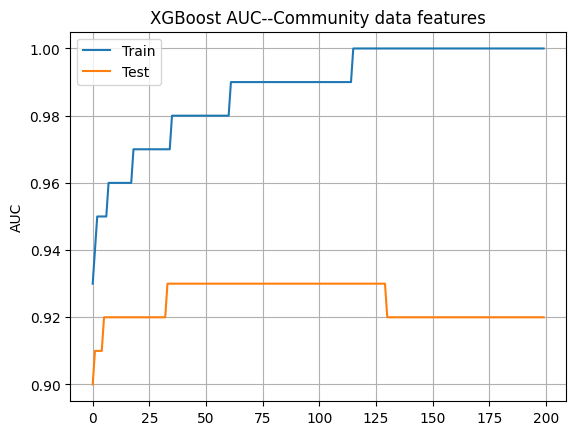

In [117]:
# 11.1 Learning curve: Modeling with transformed data:
#      We get results better than with all features:

results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, np.round(results['validation_0']['auc'],2), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],2), label='Test');
ax.legend();
ax.grid()
plt.ylabel('AUC');
plt.title('XGBoost AUC--Community data features');
plt.show();

### PCA of community data:

In [118]:
# 20.0 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
fg_tr[0][:] = si.fit_transform(fg_tr[0])
fg_tr[0].head(3)

,a_projected_c.gml,a_projected_d.gml,a_projected_i.gml,a_projected_j.gml,a_projected_h.gml,c_projected_a.gml,c_projected_d.gml,c_projected_i.gml,c_projected_j.gml,c_projected_h.gml,...,j_projected_a.gml,j_projected_c.gml,j_projected_d.gml,j_projected_i.gml,j_projected_h.gml,h_projected_a.gml,h_projected_c.gml,h_projected_d.gml,h_projected_i.gml,h_projected_j.gml
3936,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
10856,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


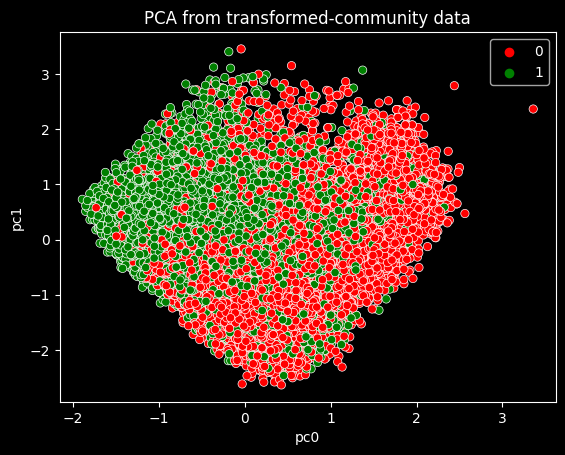

In [119]:
# 20.1 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(fg_tr[0]))
commu_pca.shape

# 20.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(commu_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

# 20.3 PCA plot of transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = commu_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed-community data') ;

## Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_classif



In [ ]:
mi_scores = utils.calMIScores(train_trans[colList], ytr)
mi_scores[::3]  # show a few features with their MI scores

eig_area_mean_ck_concavity_worst_p_concavity_mean       0.411510
eig_area_mean_ck_area_mean_p_area_se                    0.398181
eig_area_mean_ck_area_mean_p_texture_mean               0.396951
eig_area_mean_ck_area_se_p_concavity_worst              0.388818
eig_area_mean_ck_area_mean_p_concavity_worst            0.386731
                                                          ...   
deg_texture_mean_ck_concavity_worst_p_concavity_mean    0.048080
eig_area_se_ck_concavity_worst                          0.043185
deg_texture_mean_ck_area_mean_p_concavity_worst         0.032534
bet_texture_mean_ck_area_se                             0.011870
pr_texture_mean_ck_area_se                              0.000000
Name: MI Scores, Length: 90, dtype: float64

In [ ]:
fe.cumsum()
len(fe)